# Regresion Anual de Delitos por Municipio

## Descripcion del Modelo

Este notebook implementa un modelo de **regresion supervisada** para predecir la cantidad de delitos anuales por municipio en Santander.

### Dataset
Incluye datos anuales agregados por municipio:
- **Conteos totales por anio**: Total de delitos y por tipo
- **Tendencias anuales**: Evolucion temporal de la criminalidad
- **Tasas por 100 mil habitantes**: Normalizacion poblacional
- **Variables demograficas agregadas**: Poblacion, densidad, area

### Algoritmos Implementados
- **XGBoost Regressor**: Modelo principal (robusto a outliers)
- **Random Forest Regressor**: Modelo alternativo
- **Gradient Boosting**: Modelo de comparacion

### Preguntas que Responde
1. Cual sera la cantidad de delitos el proximo anio?
2. Que municipios tienen tendencias ascendentes/descendentes?
3. Que factores influyen mas en la variacion anual?

### Utilidad
- Planeacion estrategica a largo plazo
- Comparativos anuales para informes institucionales
- Proyecciones para asignacion de recursos

In [ ]:
# =============================================================================
# CONFIGURACION E IMPORTACIONES
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import warnings
import joblib
import json
from datetime import datetime

# Sklearn - Preprocesamiento
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV

# Sklearn - Modelos
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet

# XGBoost
try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("[AVISO] XGBoost no instalado. Usar: pip install xgboost")

# Sklearn - Metricas
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

warnings.filterwarnings('ignore')

# Configuracion de visualizacion
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'regression_annual_dataset.parquet'
OUTPUT_DIR = BASE_DIR / 'models' / 'predictivos' / 'regression_annual'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("Dataset:", DATA_PATH)
print("Output:", OUTPUT_DIR)

Dataset: /home/byverbel/challenges/Datos-al-Ecosistema/data/gold/model/regression_annual_dataset.parquet
Output: /home/byverbel/challenges/Datos-al-Ecosistema/models/regression/annual


## 1. Carga y Exploracion Inicial de Datos

In [ ]:
# 1.1 Cargar datos
df = pd.read_parquet(DATA_PATH)

print("=" * 70)
print("INFORMACION GENERAL DEL DATASET")
print("=" * 70)
print(f"\n> Shape: {df.shape[0]:,} registros x {df.shape[1]} columnas")
print(f"> Periodo: {df['anio'].min()} - {df['anio'].max()}")
print(f"> Municipios: {df['codigo_municipio'].nunique()}")

print("\nColumnas disponibles:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

df.head()

INFORMACION GENERAL DEL DATASET

> Shape: 1,387 registros x 26 columnas
> Periodo: 2010 - 2025
> Municipios: 87

Columnas disponibles:
    1. codigo_municipio
    2. anio
    3. poblacion_total
    4. poblacion_menores
    5. poblacion_adultos
    6. poblacion_adolescentes
    7. area_km2
    8. densidad_poblacional
    9. centros_por_km2
   10. total_delitos
   11. ABIGEATO
   12. HURTOS
   13. LESIONES
   14. VIOLENCIA INTRAFAMILIAR
   15. AMENAZAS
   16. DELITOS SEXUALES
   17. EXTORSION
   18. HOMICIDIOS
   19. tasa_abigeato
   20. tasa_hurtos
   21. tasa_lesiones
   22. tasa_violencia intrafamiliar
   23. tasa_amenazas
   24. tasa_delitos sexuales
   25. tasa_extorsion
   26. tasa_homicidios


,codigo_municipio,anio,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,area_km2,densidad_poblacional,centros_por_km2,total_delitos,ABIGEATO,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,tasa_abigeato,tasa_hurtos,tasa_lesiones,tasa_violencia intrafamiliar,tasa_amenazas,tasa_delitos sexuales,tasa_extorsion,tasa_homicidios
0,68001,2010,1048060.0,122333.0,879556.0,46171.0,152.915686,6853.842316,0.00654,5995,2,303,3814,1002,360,319,27,168,0.190829,28.910559,363.910463,95.605213,34.349178,30.437189,2.576188,16.029617
1,68001,2011,1050238.0,120475.0,884052.0,45711.0,152.915686,6868.085459,0.00654,10095,0,3032,4590,1529,378,389,17,160,0.000000,288.696467,437.043794,145.586048,35.991842,37.039223,1.618681,15.234642
2,68001,2012,1052112.0,118590.0,888231.0,45291.0,152.915686,6880.340579,0.00654,10793,0,3417,4750,1530,441,462,36,157,0.000000,324.775309,451.472847,145.421780,41.915690,43.911675,3.421689,14.922366
3,68001,2013,1053654.0,116697.0,892060.0,44897.0,152.915686,6890.424567,0.00654,10593,0,3353,4641,1443,510,435,45,166,0.000000,318.225907,440.467174,136.951979,48.402986,41.284900,4.270852,15.754697
4,68001,2014,1054902.0,114813.0,895621.0,44468.0,152.915686,6898.585927,0.00654,10110,2,3032,4175,1879,499,328,53,142,0.189591,287.420064,395.771361,178.120811,47.302972,31.092936,5.024163,13.460966


In [ ]:
# 1.2 Tipos de datos y valores nulos
print("=" * 70)
print("TIPOS DE DATOS Y VALORES NULOS")
print("=" * 70)

print("\n> Dtypes:")
print(df.dtypes)

print("\n" + "=" * 70)
print("VALORES NULOS")
print("=" * 70)
null_counts = df.isnull().sum()
null_pct = (null_counts / len(df) * 100).round(2)
null_df = pd.DataFrame({'Nulos': null_counts, 'Porcentaje': null_pct})
null_df = null_df[null_df['Nulos'] > 0]

if len(null_df) > 0:
    print(null_df)
else:
    print("[OK] No hay valores nulos en el dataset")

TIPOS DE DATOS Y VALORES NULOS

> Dtypes:
codigo_municipio                  Int64
anio                              Int64
poblacion_total                 float64
poblacion_menores               float64
poblacion_adultos               float64
poblacion_adolescentes          float64
area_km2                        float64
densidad_poblacional            float64
centros_por_km2                 float64
total_delitos                     int64
ABIGEATO                          int64
HURTOS                            int64
LESIONES                          int64
VIOLENCIA INTRAFAMILIAR           int64
AMENAZAS                          int64
DELITOS SEXUALES                  int64
EXTORSION                         int64
HOMICIDIOS                        int64
tasa_abigeato                   float64
tasa_hurtos                     float64
tasa_lesiones                   float64
tasa_violencia intrafamiliar    float64
tasa_amenazas                   float64
tasa_delitos sexuales           float6

In [ ]:
# 1.3 Estadisticas descriptivas
print("=" * 70)
print("ESTADISTICAS DESCRIPTIVAS")
print("=" * 70)

df.describe().T

ESTADISTICAS DESCRIPTIVAS


,count,mean,std,min,25%,50%,75%,max
codigo_municipio,1387.0,68409.178082,243.218224,68001.0,68209.0,68370.0,68615.0,68895.0
anio,1387.0,2017.50036,4.610731,2010.0,2013.5,2018.0,2021.5,2025.0
poblacion_total,1387.0,36914.219899,111679.202026,1314.0,4706.0,9227.0,20781.0,1056994.0
poblacion_menores,1387.0,5777.929344,15408.867096,273.0,810.5,1463.0,3111.5,122333.0
poblacion_adultos,1387.0,29052.873107,91464.57961,857.0,3534.5,6978.0,14929.5,904922.0
poblacion_adolescentes,1387.0,2083.417448,5844.264094,89.0,278.5,494.0,1056.0,46171.0
area_km2,1387.0,352.305937,444.575058,19.694442,89.593085,201.731576,431.248709,3174.288539
densidad_poblacional,1387.0,198.723716,758.9335,6.373106,23.813228,45.097825,81.062348,6912.266669
centros_por_km2,1387.0,0.020444,0.020635,0.002687,0.008232,0.013774,0.024065,0.13264
total_delitos,1387.0,347.656813,1423.349646,1.0,15.0,33.0,90.5,17940.0


DISTRIBUCION DEL TARGET: total_delitos


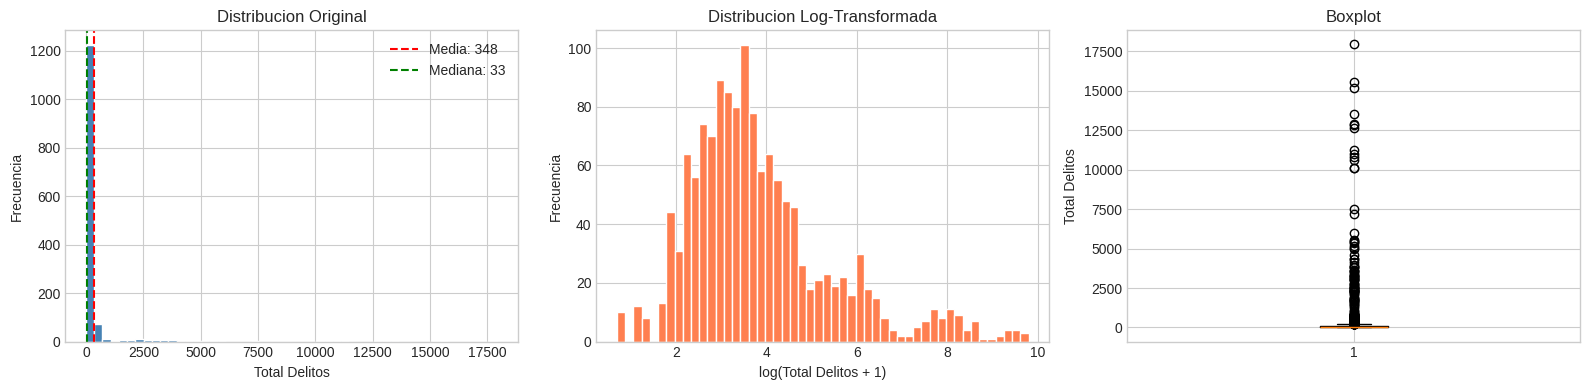


> Skewness: 7.42 (Alta asimetria positiva)
> Kurtosis: 64.38

[NOTA] Distribucion muy sesgada. Se recomienda log-transform o modelos robustos.


In [ ]:
# 1.4 Distribucion del target (total_delitos)
print("=" * 70)
print("DISTRIBUCION DEL TARGET: total_delitos")
print("=" * 70)

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histograma original
axes[0].hist(df['total_delitos'], bins=50, color='steelblue', edgecolor='white')
axes[0].set_xlabel('Total Delitos')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribucion Original')
axes[0].axvline(df['total_delitos'].mean(), color='red', linestyle='--', label=f"Media: {df['total_delitos'].mean():.0f}")
axes[0].axvline(df['total_delitos'].median(), color='green', linestyle='--', label=f"Mediana: {df['total_delitos'].median():.0f}")
axes[0].legend()

# Log-transform
df_log = np.log1p(df['total_delitos'])
axes[1].hist(df_log, bins=50, color='coral', edgecolor='white')
axes[1].set_xlabel('log(Total Delitos + 1)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribucion Log-Transformada')

# Boxplot
axes[2].boxplot(df['total_delitos'].dropna())
axes[2].set_ylabel('Total Delitos')
axes[2].set_title('Boxplot')

plt.tight_layout()
plt.show()

# Estadisticas de asimetria
skewness = df['total_delitos'].skew()
kurtosis = df['total_delitos'].kurtosis()
print(f"\n> Skewness: {skewness:.2f} {'(Alta asimetria positiva)' if skewness > 1 else ''}")
print(f"> Kurtosis: {kurtosis:.2f}")
print(f"\n[NOTA] Distribucion muy sesgada. Se recomienda log-transform o modelos robustos.")

---
## 2. Analisis Exploratorio de Datos (EDA)

In [ ]:
# 2.1 Definir categorias de variables
print("=" * 70)
print("CATEGORIZACION DE VARIABLES")
print("=" * 70)

# Variables de identificacion (NO para modelo)
ID_COLS = ['codigo_municipio']

# Variable temporal
TEMPORAL_COLS = ['anio']

# Variables demograficas
DEMO_COLS = ['poblacion_total', 'poblacion_menores', 'poblacion_adultos', 
             'poblacion_adolescentes', 'area_km2', 'densidad_poblacional', 'centros_por_km2']

# Variables de conteo de delitos (potenciales features)
DELITOS_COLS = ['ABIGEATO', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 
                'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS']

# Variables de tasas
TASA_COLS = [c for c in df.columns if c.startswith('tasa_')]

# Target principal
TARGET = 'total_delitos'

# Columnas numericas para correlaciones
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print(f"\n> Variables ID: {len(ID_COLS)}")
print(f"> Variables Temporales: {len(TEMPORAL_COLS)}")
print(f"> Variables Demograficas: {len(DEMO_COLS)}")
print(f"> Variables de Delitos: {len(DELITOS_COLS)}")
print(f"> Variables de Tasas: {len(TASA_COLS)}")
print(f"> Variables Numericas (total): {len(numeric_cols)}")
print(f"> Target: {TARGET}")

CATEGORIZACION DE VARIABLES

> Variables ID: 1
> Variables Temporales: 1
> Variables Demograficas: 7
> Variables de Delitos: 8
> Variables de Tasas: 8
> Variables Numericas (total): 26
> Target: total_delitos


TENDENCIAS TEMPORALES

> Delitos por anio:
      Total    Promedio  Mediana     Desv_Std
anio                                         
2010  16856  196.000000     23.0   712.754541
2011  24165  277.758621     35.0  1146.867026
2012  26277  302.034483     29.0  1252.031312
2013  26408  303.540230     22.0  1242.786964
2014  26671  306.563218     29.0  1203.190813
2015  23213  266.816092     30.0   966.295991
2016  33950  399.411765     34.0  1587.039879
2017  31358  360.436782     39.0  1393.099403
2018  49555  569.597701     65.0  2186.407904
2019  33343  383.252874     35.0  1538.502951
2020  27290  313.678161     31.0  1297.689445
2021  33540  390.000000     33.0  1599.003513
2022  19187  220.540230     22.0   737.261365
2023  36684  421.655172     32.0  1784.469688
2024  32363  376.313953     33.0  1517.727584
2025  41340  475.172414     50.0  1854.500241


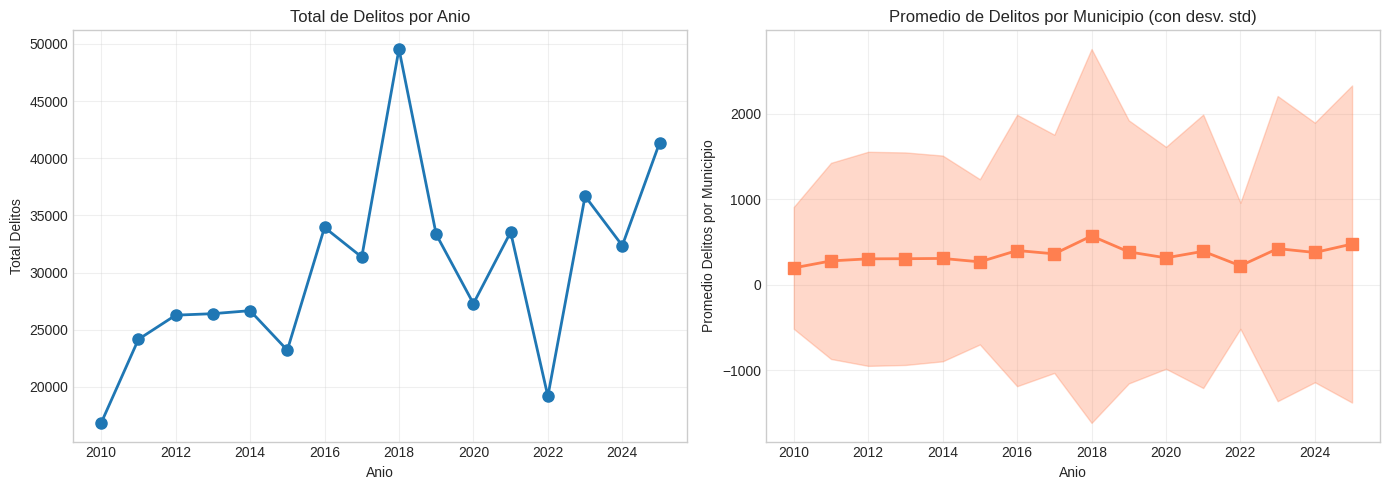

In [ ]:
# 2.2 Tendencias temporales
print("=" * 70)
print("TENDENCIAS TEMPORALES")
print("=" * 70)

# Delitos totales por anio
delitos_por_anio = df.groupby('anio')['total_delitos'].agg(['sum', 'mean', 'median', 'std'])
delitos_por_anio.columns = ['Total', 'Promedio', 'Mediana', 'Desv_Std']

print("\n> Delitos por anio:")
print(delitos_por_anio)

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total por anio
axes[0].plot(delitos_por_anio.index, delitos_por_anio['Total'], 'o-', linewidth=2, markersize=8)
axes[0].set_xlabel('Anio')
axes[0].set_ylabel('Total Delitos')
axes[0].set_title('Total de Delitos por Anio')
axes[0].grid(True, alpha=0.3)

# Promedio por anio
axes[1].plot(delitos_por_anio.index, delitos_por_anio['Promedio'], 's-', color='coral', linewidth=2, markersize=8)
axes[1].fill_between(delitos_por_anio.index, 
                     delitos_por_anio['Promedio'] - delitos_por_anio['Desv_Std'],
                     delitos_por_anio['Promedio'] + delitos_por_anio['Desv_Std'],
                     alpha=0.3, color='coral')
axes[1].set_xlabel('Anio')
axes[1].set_ylabel('Promedio Delitos por Municipio')
axes[1].set_title('Promedio de Delitos por Municipio (con desv. std)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

ANALISIS DE CORRELACIONES

> Top 10 correlaciones positivas con total_delitos:
DELITOS SEXUALES           0.964224
VIOLENCIA INTRAFAMILIAR    0.957609
HURTOS                     0.934263
poblacion_adolescentes     0.930236
poblacion_menores          0.925004
LESIONES                   0.921370
HOMICIDIOS                 0.872263
poblacion_total            0.864110
AMENAZAS                   0.842128
EXTORSION                  0.840358
Name: total_delitos, dtype: float64

> Top 10 correlaciones negativas con total_delitos:
ABIGEATO                 0.231712
tasa_amenazas            0.128417
tasa_extorsion           0.112737
tasa_homicidios          0.104524
area_km2                 0.062557
tasa_delitos sexuales    0.057665
anio                     0.033412
tasa_abigeato           -0.045303
centros_por_km2         -0.063812
codigo_municipio        -0.199007
Name: total_delitos, dtype: float64


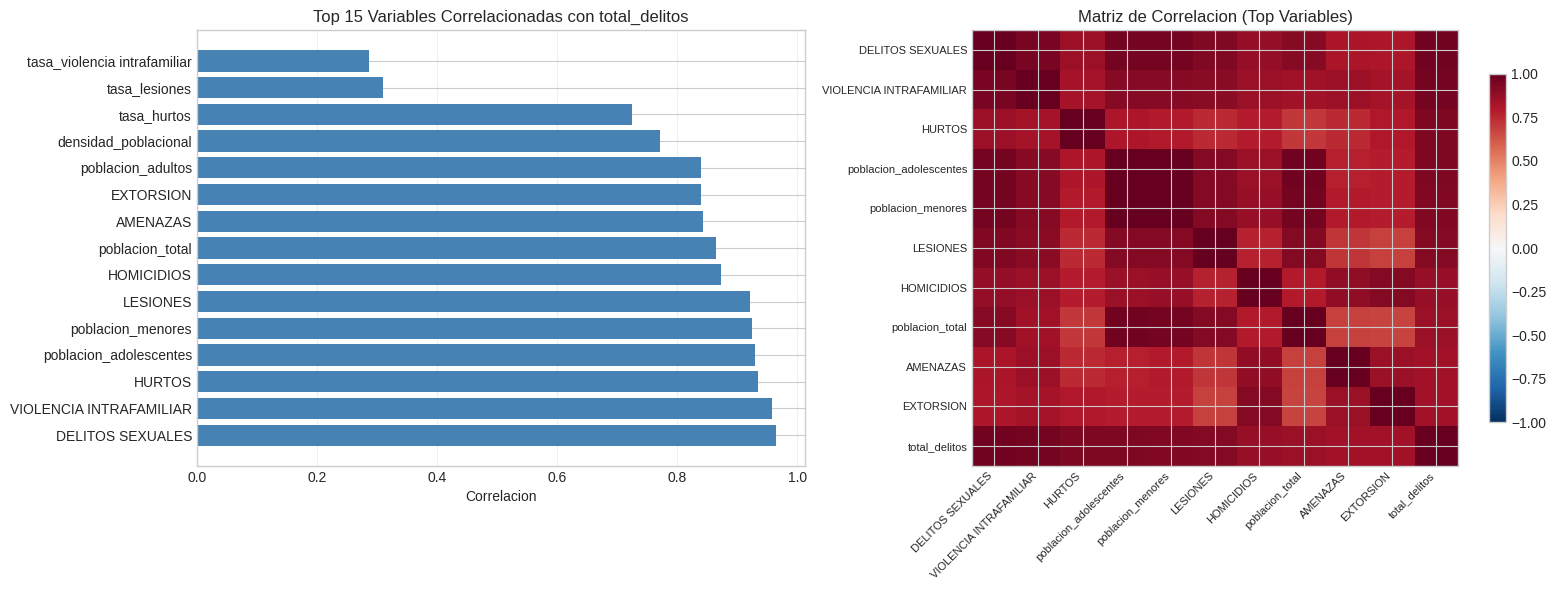

In [ ]:
# 2.3 Analisis de correlaciones
print("=" * 70)
print("ANALISIS DE CORRELACIONES")
print("=" * 70)

# Correlaciones con la variable objetivo
correlaciones = df[numeric_cols].corr()['total_delitos'].drop('total_delitos').sort_values(ascending=False)

print("\n> Top 10 correlaciones positivas con total_delitos:")
print(correlaciones.head(10))
print("\n> Top 10 correlaciones negativas con total_delitos:")
print(correlaciones.tail(10))

# Heatmap de correlaciones
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlaciones con target
axes[0].barh(correlaciones.head(15).index, correlaciones.head(15).values, color='steelblue')
axes[0].set_xlabel('Correlacion')
axes[0].set_title('Top 15 Variables Correlacionadas con total_delitos')
axes[0].axvline(x=0, color='black', linewidth=0.5)
axes[0].grid(True, alpha=0.3, axis='x')

# Matriz de correlacion (variables mas relevantes)
top_vars = list(correlaciones.abs().nlargest(10).index) + ['total_delitos']
corr_matrix = df[top_vars].corr()
im = axes[1].imshow(corr_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)
axes[1].set_xticks(range(len(top_vars)))
axes[1].set_yticks(range(len(top_vars)))
axes[1].set_xticklabels(top_vars, rotation=45, ha='right', fontsize=8)
axes[1].set_yticklabels(top_vars, fontsize=8)
axes[1].set_title('Matriz de Correlacion (Top Variables)')
plt.colorbar(im, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()

ANALISIS GEOGRAFICO

> Top 10 municipios con mas delitos (promedio anual):
codigo_municipio
68001    11468.1250
68081     4064.8750
68276     3312.8125
68307     2455.1250
68547     2102.7500
68679      720.5000
68077      568.1250
68655      463.6250
68190      423.7500
68406      414.5000
Name: total_delitos, dtype: float64

> Top 10 municipios con menos delitos (promedio anual):
codigo_municipio
68370     4.230769
68160     5.714286
68686     5.812500
68522     7.312500
68013     7.937500
68264     8.375000
68673     8.750000
68425     9.000000
68245     9.375000
68705    10.000000
Name: total_delitos, dtype: float64


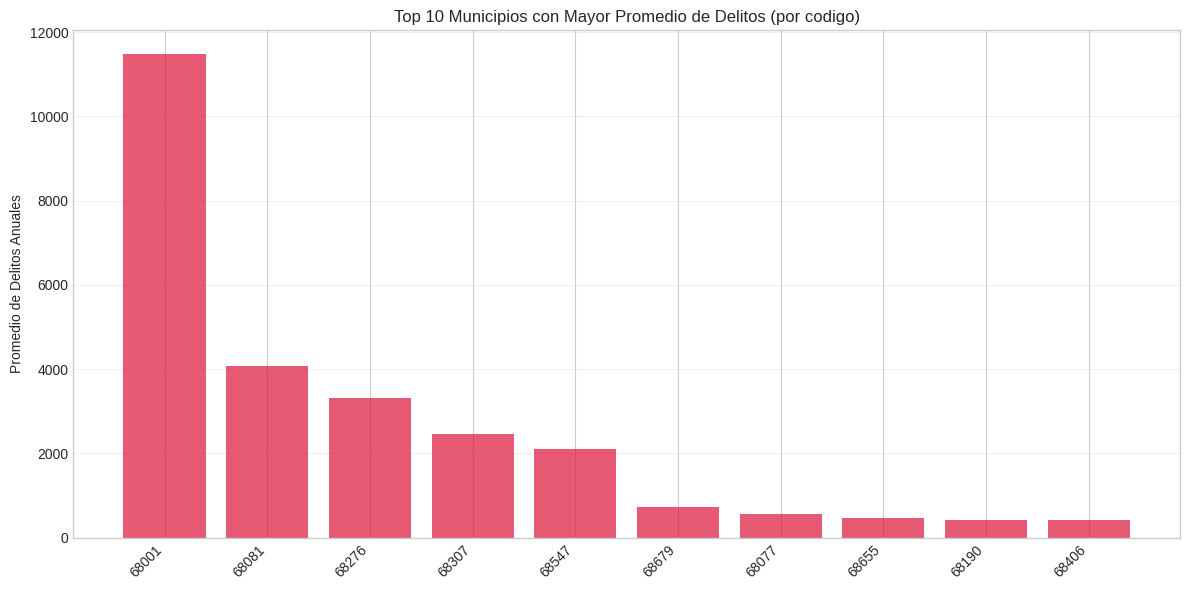

In [ ]:
# 2.4 Analisis geografico
print("=" * 70)
print("ANALISIS GEOGRAFICO")
print("=" * 70)

# Top municipios por delitos totales promedio (usando codigo_municipio)
top_municipios = df.groupby('codigo_municipio')['total_delitos'].mean().nlargest(10)
print("\n> Top 10 municipios con mas delitos (promedio anual):")
print(top_municipios)

# Municipios con menor cantidad de delitos
bottom_municipios = df.groupby('codigo_municipio')['total_delitos'].mean().nsmallest(10)
print("\n> Top 10 municipios con menos delitos (promedio anual):")
print(bottom_municipios)

# Visualizacion
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(top_municipios))
ax.bar(x, top_municipios.values, color='crimson', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels([str(c) for c in top_municipios.index], rotation=45, ha='right')
ax.set_ylabel('Promedio de Delitos Anuales')
ax.set_title('Top 10 Municipios con Mayor Promedio de Delitos (por codigo)')
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 3. Preprocesamiento de Datos

Preparacion de datos para el modelo de regresion:
- Ingenieria de caracteristicas (features temporales, lag variables)
- Seleccion de variables relevantes
- Division train/test
- Escalado de variables

In [ ]:
# 3.1 Ingenieria de caracteristicas
print("=" * 70)
print("INGENIERIA DE CARACTERISTICAS")
print("=" * 70)

# Crear copia para preprocesamiento
df_model = df.copy()

# Variables temporales
df_model['anio_normalizado'] = df_model['anio'] - df_model['anio'].min()
df_model['es_post_2020'] = (df_model['anio'] >= 2020).astype(int)  # Efecto pandemia

# Variables lag por municipio (delitos del anio anterior)
df_model = df_model.sort_values(['codigo_municipio', 'anio'])
df_model['total_delitos_lag1'] = df_model.groupby('codigo_municipio')['total_delitos'].shift(1)
df_model['total_delitos_lag2'] = df_model.groupby('codigo_municipio')['total_delitos'].shift(2)

# Tasa de crecimiento
df_model['crecimiento_delitos'] = df_model.groupby('codigo_municipio')['total_delitos'].pct_change()

# Media movil de delitos (ultimos 3 anios)
df_model['delitos_media_movil_3'] = df_model.groupby('codigo_municipio')['total_delitos'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

print(f"> Variables originales: {len(df.columns)}")
print(f"> Variables despues de ingenieria: {len(df_model.columns)}")
print(f"\n> Nuevas variables creadas:")
nuevas_vars = ['anio_normalizado', 'es_post_2020', 'total_delitos_lag1', 
               'total_delitos_lag2', 'crecimiento_delitos', 'delitos_media_movil_3']
for var in nuevas_vars:
    print(f"  - {var}")

# Eliminar filas con valores nulos (por lag)
print(f"\n> Filas antes de eliminar nulos: {len(df_model)}")
df_model = df_model.dropna(subset=['total_delitos_lag1', 'total_delitos_lag2'])
print(f"> Filas despues de eliminar nulos: {len(df_model)}")

INGENIERIA DE CARACTERISTICAS
> Variables originales: 26
> Variables despues de ingenieria: 32

> Nuevas variables creadas:
  - anio_normalizado
  - es_post_2020
  - total_delitos_lag1
  - total_delitos_lag2
  - crecimiento_delitos
  - delitos_media_movil_3

> Filas antes de eliminar nulos: 1387
> Filas despues de eliminar nulos: 1213


In [ ]:
# 3.2 Seleccion de variables para el modelo
print("=" * 70)
print("SELECCION DE VARIABLES")
print("=" * 70)

# Definir variable objetivo
target = 'total_delitos'

# Variables a excluir del modelo
exclude_cols = [
    target,                    # Variable objetivo
    'anio',                    # Usamos anio_normalizado
    'codigo_municipio',        # Identificador
    'crecimiento_delitos',     # Puede tener inf
]

# Variables que son tasas derivadas del target (evitar data leakage)
tasa_cols = [col for col in df_model.columns if 'tasa_' in col]
exclude_cols.extend(tasa_cols)

# Seleccionar features
feature_cols = [col for col in df_model.columns if col not in exclude_cols and df_model[col].dtype in ['int64', 'float64']]

print(f"> Variable objetivo: {target}")
print(f"> Numero de features: {len(feature_cols)}")
print(f"\n> Features seleccionadas:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i:2d}. {col}")

# Crear X e y
X = df_model[feature_cols].copy()
y = df_model[target].copy()

print(f"\n> Shape de X: {X.shape}")
print(f"> Shape de y: {y.shape}")

SELECCION DE VARIABLES
> Variable objetivo: total_delitos
> Numero de features: 19

> Features seleccionadas:
   1. poblacion_total
   2. poblacion_menores
   3. poblacion_adultos
   4. poblacion_adolescentes
   5. area_km2
   6. densidad_poblacional
   7. centros_por_km2
   8. ABIGEATO
   9. HURTOS
  10. LESIONES
  11. VIOLENCIA INTRAFAMILIAR
  12. AMENAZAS
  13. DELITOS SEXUALES
  14. EXTORSION
  15. HOMICIDIOS
  16. es_post_2020
  17. total_delitos_lag1
  18. total_delitos_lag2
  19. delitos_media_movil_3

> Shape de X: (1213, 19)
> Shape de y: (1213,)


In [ ]:
# 3.3 Division train/test
print("=" * 70)
print("DIVISION TRAIN/TEST")
print("=" * 70)

# Division temporal: ultimos 2 anios como test
anio_corte = df_model['anio'].max() - 1  # Ultimo anio completo como test

# Indices de train y test basados en anio
train_mask = df_model['anio'] < anio_corte
test_mask = df_model['anio'] >= anio_corte

X_train = X[train_mask]
X_test = X[test_mask]
y_train = y[train_mask]
y_test = y[test_mask]

print(f"> Anio de corte: {anio_corte}")
print(f"> Datos de entrenamiento: anios < {anio_corte}")
print(f"> Datos de test: anios >= {anio_corte}")
print(f"\n> Train set: {X_train.shape[0]} muestras ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"> Test set: {X_test.shape[0]} muestras ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\n> Distribucion del target:")
print(f"  Train - Media: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"  Test  - Media: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

DIVISION TRAIN/TEST
> Anio de corte: 2024
> Datos de entrenamiento: anios < 2024
> Datos de test: anios >= 2024

> Train set: 1040 muestras (85.7%)
> Test set: 173 muestras (14.3%)

> Distribucion del target:
  Train - Media: 353.34, Std: 1440.52
  Test  - Media: 426.03, Std: 1691.27


In [ ]:
# 3.4 Escalado de variables
print("=" * 70)
print("ESCALADO DE VARIABLES")
print("=" * 70)

from sklearn.preprocessing import StandardScaler

# Crear scaler
scaler = StandardScaler()

# Ajustar solo con datos de entrenamiento
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertir a DataFrame para mantener nombres de columnas
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("[OK] Escalado completado con StandardScaler")
print(f"\n> Estadisticas de train escalado:")
print(f"  Media (primeras 5 cols): {X_train_scaled.iloc[:, :5].mean().values.round(4)}")
print(f"  Std (primeras 5 cols): {X_train_scaled.iloc[:, :5].std().values.round(4)}")

ESCALADO DE VARIABLES
[OK] Escalado completado con StandardScaler

> Estadisticas de train escalado:
  Media (primeras 5 cols): [ 0. -0. -0. -0. -0.]
  Std (primeras 5 cols): [1.0005 1.0005 1.0005 1.0005 1.0005]


## 4. Modelos Base de Regresion

Entrenamiento de multiples modelos de regresion para comparar rendimiento:
- Linear Regression (baseline)
- Ridge Regression
- Lasso Regression
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost Regressor

In [ ]:
# 4.1 Definicion de modelos y metricas
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Intentar importar XGBoost
try:
    from xgboost import XGBRegressor
    xgboost_available = True
except ImportError:
    xgboost_available = False
    print("[AVISO] XGBoost no esta instalado. Se omitira este modelo.")

# Definir modelos base
modelos = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
}

if xgboost_available:
    modelos['XGBoost'] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, verbosity=0)

def evaluar_modelo(y_true, y_pred, nombre_modelo):
    """Calcula metricas de evaluacion para regresion."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1))) * 100
    
    return {
        'Modelo': nombre_modelo,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

print(f"[OK] {len(modelos)} modelos definidos para entrenamiento")
for nombre in modelos.keys():
    print(f"  - {nombre}")

[OK] 7 modelos definidos para entrenamiento
  - LinearRegression
  - Ridge
  - Lasso
  - ElasticNet
  - RandomForest
  - GradientBoosting
  - XGBoost


In [ ]:
# 4.2 Entrenamiento y evaluacion de modelos base
print("=" * 70)
print("ENTRENAMIENTO DE MODELOS BASE")
print("=" * 70)

resultados = []
modelos_entrenados = {}

for nombre, modelo in modelos.items():
    print(f"\n> Entrenando {nombre}...", end=" ")
    
    # Usar datos escalados para modelos lineales, sin escalar para basados en arboles
    if nombre in ['LinearRegression', 'Ridge', 'Lasso', 'ElasticNet']:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train, X_test
    
    # Entrenar
    modelo.fit(X_tr, y_train)
    modelos_entrenados[nombre] = modelo
    
    # Predecir
    y_pred_train = modelo.predict(X_tr)
    y_pred_test = modelo.predict(X_te)
    
    # Evaluar
    metricas_train = evaluar_modelo(y_train, y_pred_train, nombre)
    metricas_test = evaluar_modelo(y_test, y_pred_test, nombre)
    
    resultados.append({
        'Modelo': nombre,
        'R2_Train': metricas_train['R2'],
        'R2_Test': metricas_test['R2'],
        'RMSE_Train': metricas_train['RMSE'],
        'RMSE_Test': metricas_test['RMSE'],
        'MAE_Test': metricas_test['MAE'],
        'MAPE_Test': metricas_test['MAPE']
    })
    
    print(f"R2 Train: {metricas_train['R2']:.4f}, R2 Test: {metricas_test['R2']:.4f}")

print("\n" + "=" * 70)
print("[OK] Entrenamiento de modelos base completado")

ENTRENAMIENTO DE MODELOS BASE

> Entrenando LinearRegression... R2 Train: 1.0000, R2 Test: 1.0000

> Entrenando Ridge... R2 Train: 1.0000, R2 Test: 1.0000

> Entrenando Lasso... R2 Train: 1.0000, R2 Test: 1.0000

> Entrenando ElasticNet... R2 Train: 0.9764, R2 Test: 0.9870

> Entrenando RandomForest... R2 Train: 1.0000, R2 Test: 1.0000

> Entrenando Lasso... R2 Train: 1.0000, R2 Test: 1.0000

> Entrenando ElasticNet... R2 Train: 0.9764, R2 Test: 0.9870

> Entrenando RandomForest... R2 Train: 0.9912, R2 Test: 0.9780

> Entrenando GradientBoosting... R2 Train: 0.9912, R2 Test: 0.9780

> Entrenando GradientBoosting... R2 Train: 0.9999, R2 Test: 0.9943

> Entrenando XGBoost... R2 Train: 0.9999, R2 Test: 0.9943

> Entrenando XGBoost... R2 Train: 1.0000, R2 Test: 0.9724

[OK] Entrenamiento de modelos base completado
R2 Train: 1.0000, R2 Test: 0.9724

[OK] Entrenamiento de modelos base completado


COMPARACION DE MODELOS BASE

> Ranking de modelos por R2 en Test:
          Modelo  R2_Train  R2_Test   RMSE_Train    RMSE_Test     MAE_Test    MAPE_Test
LinearRegression  1.000000 1.000000 3.566152e-12 4.234343e-12 1.711710e-12 5.175266e-12
           Lasso  0.999999 0.999999 1.379123e+00 1.541953e+00 6.740393e-01 2.224359e+00
           Ridge  0.999998 0.999994 1.957953e+00 4.144391e+00 1.295686e+00 2.005387e+00
GradientBoosting  0.999920 0.994320 1.287850e+01 1.270897e+02 3.133556e+01 2.018174e+01
      ElasticNet  0.976435 0.987023 2.210283e+02 1.921067e+02 5.529961e+01 1.084060e+02
    RandomForest  0.991176 0.978017 1.352526e+02 2.500354e+02 4.815035e+01 1.434230e+01
         XGBoost  1.000000 0.972396 4.360452e-01 2.801808e+02 4.602155e+01 8.170414e+00

[MEJOR] Mejor modelo base: LinearRegression con R2 Test = 1.0000


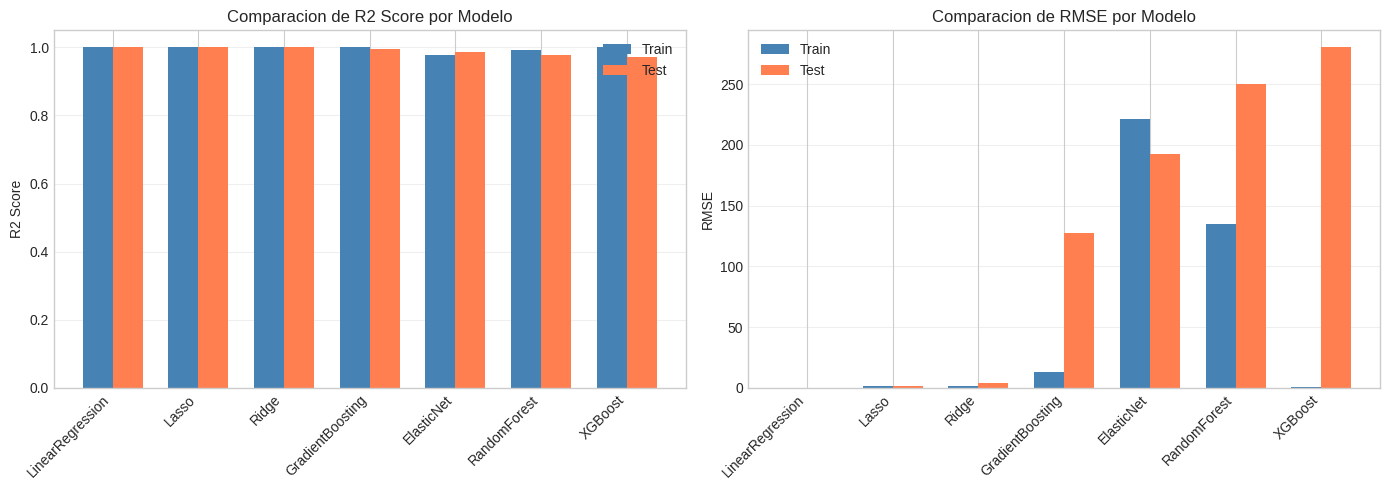

In [ ]:
# 4.3 Comparacion de modelos base
print("=" * 70)
print("COMPARACION DE MODELOS BASE")
print("=" * 70)

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values('R2_Test', ascending=False)

print("\n> Ranking de modelos por R2 en Test:")
print(df_resultados.to_string(index=False))

# Identificar mejor modelo
mejor_modelo_nombre = df_resultados.iloc[0]['Modelo']
mejor_r2 = df_resultados.iloc[0]['R2_Test']
print(f"\n[MEJOR] Mejor modelo base: {mejor_modelo_nombre} con R2 Test = {mejor_r2:.4f}")

# Visualizacion
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Grafico de R2
x = range(len(df_resultados))
width = 0.35
axes[0].bar([i - width/2 for i in x], df_resultados['R2_Train'], width, label='Train', color='steelblue')
axes[0].bar([i + width/2 for i in x], df_resultados['R2_Test'], width, label='Test', color='coral')
axes[0].set_xticks(x)
axes[0].set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
axes[0].set_ylabel('R2 Score')
axes[0].set_title('Comparacion de R2 Score por Modelo')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Grafico de RMSE
axes[1].bar([i - width/2 for i in x], df_resultados['RMSE_Train'], width, label='Train', color='steelblue')
axes[1].bar([i + width/2 for i in x], df_resultados['RMSE_Test'], width, label='Test', color='coral')
axes[1].set_xticks(x)
axes[1].set_xticklabels(df_resultados['Modelo'], rotation=45, ha='right')
axes[1].set_ylabel('RMSE')
axes[1].set_title('Comparacion de RMSE por Modelo')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Optimizacion de Hiperparametros

Optimizacion mediante GridSearchCV de los mejores modelos:
- Random Forest Regressor
- Gradient Boosting Regressor
- XGBoost Regressor (si esta disponible)

In [ ]:
# 5.1 Definicion de grids de hiperparametros
from sklearn.model_selection import GridSearchCV, cross_val_score

print("=" * 70)
print("DEFINICION DE GRIDS DE HIPERPARAMETROS")
print("=" * 70)

# Grids para cada modelo
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
}

if xgboost_available:
    param_grids['XGBoost'] = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 1.0]
    }

for nombre, grid in param_grids.items():
    total_combinaciones = 1
    for valores in grid.values():
        total_combinaciones *= len(valores)
    print(f"> {nombre}: {total_combinaciones} combinaciones")

DEFINICION DE GRIDS DE HIPERPARAMETROS
> RandomForest: 81 combinaciones
> GradientBoosting: 108 combinaciones
> XGBoost: 162 combinaciones


In [ ]:
# 5.2 Optimizacion con GridSearchCV
print("=" * 70)
print("OPTIMIZACION DE HIPERPARAMETROS")
print("=" * 70)

resultados_optimizados = []
mejores_modelos = {}

for nombre, param_grid in param_grids.items():
    print(f"\n> Optimizando {nombre}...")
    
    # Crear modelo base
    if nombre == 'RandomForest':
        modelo_base = RandomForestRegressor(random_state=42, n_jobs=-1)
    elif nombre == 'GradientBoosting':
        modelo_base = GradientBoostingRegressor(random_state=42)
    elif nombre == 'XGBoost' and xgboost_available:
        modelo_base = XGBRegressor(random_state=42, n_jobs=-1, verbosity=0)
    else:
        continue
    
    # GridSearchCV
    grid_search = GridSearchCV(
        estimator=modelo_base,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    # Entrenar
    grid_search.fit(X_train, y_train)
    
    # Mejor modelo
    mejor_modelo = grid_search.best_estimator_
    mejores_modelos[nombre] = mejor_modelo
    
    # Evaluar en test
    y_pred_test = mejor_modelo.predict(X_test)
    metricas = evaluar_modelo(y_test, y_pred_test, nombre)
    
    resultados_optimizados.append({
        'Modelo': nombre,
        'Mejores_Params': grid_search.best_params_,
        'R2_CV': grid_search.best_score_,
        'R2_Test': metricas['R2'],
        'RMSE_Test': metricas['RMSE'],
        'MAE_Test': metricas['MAE']
    })
    
    print(f"  > Mejor R2 CV: {grid_search.best_score_:.4f}")
    print(f"  > R2 Test: {metricas['R2']:.4f}")
    print(f"  > Mejores parametros: {grid_search.best_params_}")

print("\n" + "=" * 70)
print("[OK] Optimizacion completada")

OPTIMIZACION DE HIPERPARAMETROS

> Optimizando RandomForest...
  > Mejor R2 CV: 0.8962
  > R2 Test: 0.9864
  > Mejores parametros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

> Optimizando GradientBoosting...
  > Mejor R2 CV: 0.8962
  > R2 Test: 0.9864
  > Mejores parametros: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

> Optimizando GradientBoosting...
  > Mejor R2 CV: 0.9107
  > R2 Test: 0.9921
  > Mejores parametros: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

> Optimizando XGBoost...
  > Mejor R2 CV: 0.9107
  > R2 Test: 0.9921
  > Mejores parametros: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}

> Optimizando XGBoost...
  > Mejor R2 CV: 0.9155
  > R2 Test: 0.9929
  > Mejores parametros: {'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 200, 'subsa

In [ ]:
# 5.3 Comparacion de modelos optimizados
print("=" * 70)
print("COMPARACION DE MODELOS OPTIMIZADOS")
print("=" * 70)

# Crear DataFrame de resultados
df_optimizados = pd.DataFrame(resultados_optimizados)
df_optimizados_display = df_optimizados[['Modelo', 'R2_CV', 'R2_Test', 'RMSE_Test', 'MAE_Test']].copy()
df_optimizados_display = df_optimizados_display.sort_values('R2_Test', ascending=False)

print("\n> Ranking de modelos optimizados:")
print(df_optimizados_display.to_string(index=False))

# Mejor modelo optimizado
mejor_modelo_opt_nombre = df_optimizados_display.iloc[0]['Modelo']
mejor_r2_opt = df_optimizados_display.iloc[0]['R2_Test']
print(f"\n[MEJOR] Mejor modelo optimizado: {mejor_modelo_opt_nombre} con R2 Test = {mejor_r2_opt:.4f}")

# Mejora respecto al modelo base
if mejor_modelo_opt_nombre in df_resultados['Modelo'].values:
    r2_base = df_resultados[df_resultados['Modelo'] == mejor_modelo_opt_nombre]['R2_Test'].values[0]
    mejora = mejor_r2_opt - r2_base
    print(f"> Mejora respecto a version base: {mejora:.4f} ({mejora/r2_base*100:.2f}%)")

COMPARACION DE MODELOS OPTIMIZADOS

> Ranking de modelos optimizados:
          Modelo    R2_CV  R2_Test  RMSE_Test  MAE_Test
         XGBoost 0.915499 0.992930 141.793940 30.022337
GradientBoosting 0.910676 0.992119 149.703677 30.780533
    RandomForest 0.896237 0.986432 196.430425 41.872821

[MEJOR] Mejor modelo optimizado: XGBoost con R2 Test = 0.9929
> Mejora respecto a version base: 0.0205 (2.11%)


## 6. Modelo Final y Evaluacion

Seleccion del mejor modelo, evaluacion detallada y analisis de importancia de variables.

In [ ]:
# 6.1 Seleccion del mejor modelo
print("=" * 70)
print("SELECCION DEL MEJOR MODELO")
print("=" * 70)

# Seleccionar el mejor modelo de los optimizados
mejor_modelo_final = mejores_modelos[mejor_modelo_opt_nombre]

print(f"> Modelo seleccionado: {mejor_modelo_opt_nombre}")
print(f"> Tipo: {type(mejor_modelo_final).__name__}")

# Mostrar parametros del mejor modelo
print(f"\n> Parametros del modelo:")
for param, valor in mejor_modelo_final.get_params().items():
    if valor is not None and param not in ['n_jobs', 'random_state', 'verbose', 'verbosity']:
        print(f"  - {param}: {valor}")

SELECCION DEL MEJOR MODELO
> Modelo seleccionado: XGBoost
> Tipo: XGBRegressor

> Parametros del modelo:
  - objective: reg:squarederror
  - enable_categorical: False
  - learning_rate: 0.1
  - max_depth: 7
  - min_child_weight: 3
  - missing: nan
  - n_estimators: 200
  - subsample: 0.8


In [ ]:
# 6.2 Evaluacion detallada del modelo final
print("=" * 70)
print("EVALUACION DETALLADA DEL MODELO FINAL")
print("=" * 70)

# Predicciones
y_pred_train_final = mejor_modelo_final.predict(X_train)
y_pred_test_final = mejor_modelo_final.predict(X_test)

# Metricas
metricas_train = evaluar_modelo(y_train, y_pred_train_final, 'Train')
metricas_test = evaluar_modelo(y_test, y_pred_test_final, 'Test')

print("\n> Metricas de Entrenamiento:")
print(f"  - R2:   {metricas_train['R2']:.4f}")
print(f"  - RMSE: {metricas_train['RMSE']:.2f}")
print(f"  - MAE:  {metricas_train['MAE']:.2f}")
print(f"  - MAPE: {metricas_train['MAPE']:.2f}%")

print("\n> Metricas de Test:")
print(f"  - R2:   {metricas_test['R2']:.4f}")
print(f"  - RMSE: {metricas_test['RMSE']:.2f}")
print(f"  - MAE:  {metricas_test['MAE']:.2f}")
print(f"  - MAPE: {metricas_test['MAPE']:.2f}%")

# Detectar overfitting
diff_r2 = metricas_train['R2'] - metricas_test['R2']
if diff_r2 > 0.1:
    print(f"\n[AVISO] Posible overfitting detectado (diferencia R2: {diff_r2:.4f})")
else:
    print(f"\n[OK] No se detecta overfitting significativo (diferencia R2: {diff_r2:.4f})")

EVALUACION DETALLADA DEL MODELO FINAL

> Metricas de Entrenamiento:
  - R2:   1.0000
  - RMSE: 10.08
  - MAE:  2.27
  - MAPE: 5.73%

> Metricas de Test:
  - R2:   0.9929
  - RMSE: 141.79
  - MAE:  30.02
  - MAPE: 8.77%

[OK] No se detecta overfitting significativo (diferencia R2: 0.0070)


VISUALIZACION DE PREDICCIONES


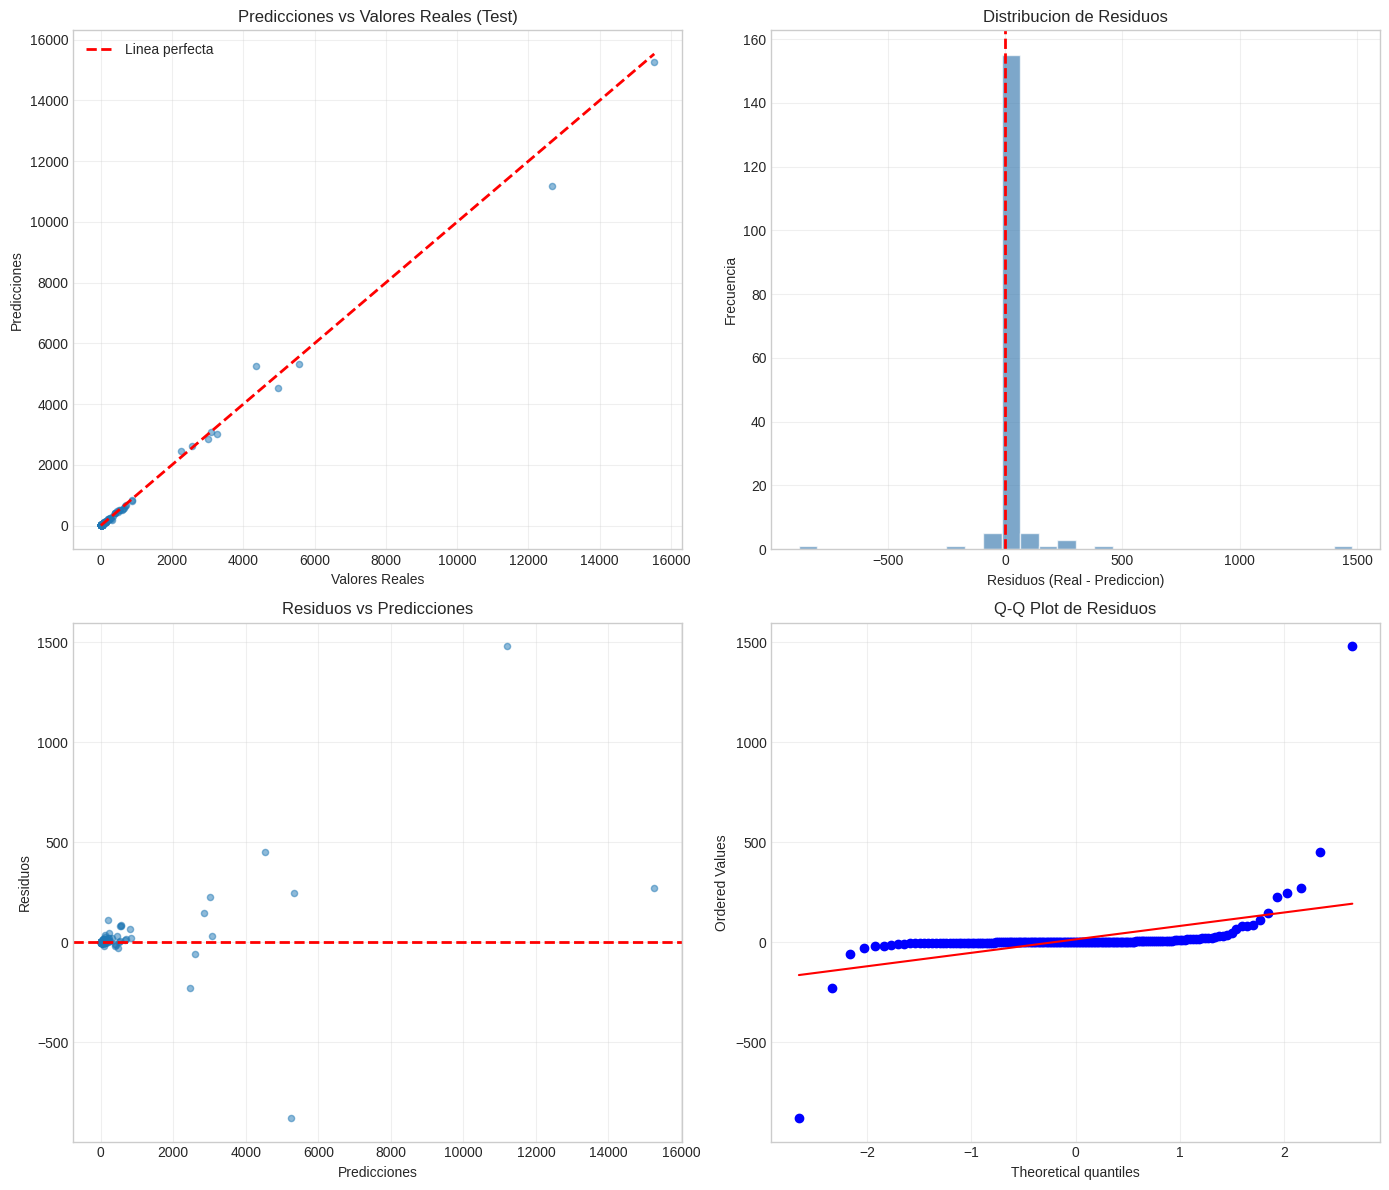


> Estadisticas de residuos:
  - Media: 14.78
  - Desv. Std: 141.02
  - Min: -878.68
  - Max: 1480.15


In [ ]:
# 6.3 Visualizacion de predicciones vs valores reales
print("=" * 70)
print("VISUALIZACION DE PREDICCIONES")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Prediccion vs Real (scatter)
axes[0, 0].scatter(y_test, y_pred_test_final, alpha=0.5, s=20)
max_val = max(y_test.max(), y_pred_test_final.max())
axes[0, 0].plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Linea perfecta')
axes[0, 0].set_xlabel('Valores Reales')
axes[0, 0].set_ylabel('Predicciones')
axes[0, 0].set_title('Predicciones vs Valores Reales (Test)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribucion de residuos
residuos = y_test.values - y_pred_test_final
axes[0, 1].hist(residuos, bins=30, color='steelblue', edgecolor='white', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuos (Real - Prediccion)')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].set_title('Distribucion de Residuos')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuos vs Predicciones
axes[1, 0].scatter(y_pred_test_final, residuos, alpha=0.5, s=20)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicciones')
axes[1, 0].set_ylabel('Residuos')
axes[1, 0].set_title('Residuos vs Predicciones')
axes[1, 0].grid(True, alpha=0.3)

# 4. QQ Plot de residuos
from scipy import stats
stats.probplot(residuos, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot de Residuos')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n> Estadisticas de residuos:")
print(f"  - Media: {residuos.mean():.2f}")
print(f"  - Desv. Std: {residuos.std():.2f}")
print(f"  - Min: {residuos.min():.2f}")
print(f"  - Max: {residuos.max():.2f}")

IMPORTANCIA DE VARIABLES

> Top 15 variables mas importantes:
               Variable  Importancia
VIOLENCIA INTRAFAMILIAR     0.548503
               LESIONES     0.262494
  delitos_media_movil_3     0.069826
                 HURTOS     0.050506
       DELITOS SEXUALES     0.044655
              EXTORSION     0.005234
      poblacion_adultos     0.003617
               AMENAZAS     0.003400
        poblacion_total     0.003179
      poblacion_menores     0.002468
     total_delitos_lag2     0.001669
     total_delitos_lag1     0.001383
             HOMICIDIOS     0.001098
               ABIGEATO     0.001079
           es_post_2020     0.000462


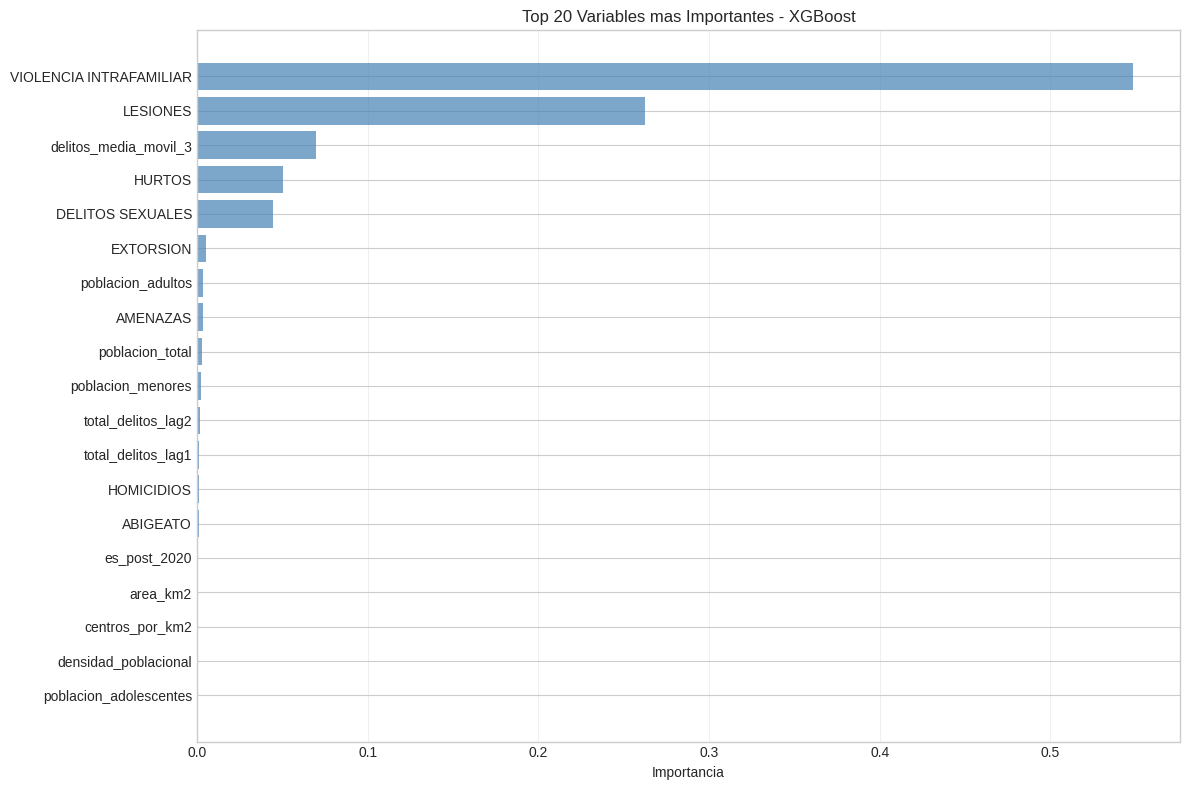

In [ ]:
# 6.4 Importancia de variables
print("=" * 70)
print("IMPORTANCIA DE VARIABLES")
print("=" * 70)

# Obtener importancia de variables (para modelos basados en arboles)
if hasattr(mejor_modelo_final, 'feature_importances_'):
    importancias = pd.DataFrame({
        'Variable': feature_cols,
        'Importancia': mejor_modelo_final.feature_importances_
    }).sort_values('Importancia', ascending=False)
    
    print("\n> Top 15 variables mas importantes:")
    print(importancias.head(15).to_string(index=False))
    
    # Visualizacion
    fig, ax = plt.subplots(figsize=(12, 8))
    top_n = 20
    importancias_top = importancias.head(top_n)
    
    y_pos = range(len(importancias_top))
    ax.barh(y_pos, importancias_top['Importancia'], color='steelblue', alpha=0.7)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(importancias_top['Variable'])
    ax.invert_yaxis()
    ax.set_xlabel('Importancia')
    ax.set_title(f'Top {top_n} Variables mas Importantes - {mejor_modelo_opt_nombre}')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("[AVISO] El modelo seleccionado no tiene atributo feature_importances_")

## 7. Guardar Modelo y Resultados

Persistencia del modelo entrenado y metadatos para uso en produccion (chatbot/dashboard).

In [ ]:
# 7.1 Preparar directorio de salida
import json
from datetime import datetime

# Directorio de salida
output_dir = Path("../models/regression/annual")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"[OK] Directorio de salida: {output_dir.absolute()}")

[OK] Directorio de salida: /home/byverbel/challenges/Datos-al-Ecosistema/notebooks/../models/regression/annual


In [ ]:
# 7.2 Guardar modelo con joblib
import joblib

# Nombre del archivo con timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"regression_annual_{mejor_modelo_opt_nombre.lower()}_{timestamp}.joblib"
model_path = output_dir / model_filename

# Guardar modelo
joblib.dump(mejor_modelo_final, model_path)
print(f"[OK] Modelo guardado: {model_path}")

# Guardar scaler (para modelos que lo requieran)
scaler_path = output_dir / f"scaler_{timestamp}.joblib"
joblib.dump(scaler, scaler_path)
print(f"[OK] Scaler guardado: {scaler_path}")

[OK] Modelo guardado: ../models/regression/annual/regression_annual_xgboost_20251128_181146.joblib
[OK] Scaler guardado: ../models/regression/annual/scaler_20251128_181146.joblib


In [ ]:
# 7.3 Crear metadatos JSON para chatbot/dashboard
print("=" * 70)
print("GENERANDO METADATOS DESCRIPTIVOS")
print("=" * 70)

# Preparar importancias para JSON
importancias_dict = {}
if hasattr(mejor_modelo_final, 'feature_importances_'):
    importancias_dict = importancias.head(20).set_index('Variable')['Importancia'].to_dict()

# Mejores parametros del modelo
mejores_params = {}
for r in resultados_optimizados:
    if r['Modelo'] == mejor_modelo_opt_nombre:
        mejores_params = r['Mejores_Params']
        break

# Crear metadatos
metadata = {
    "modelo": {
        "nombre": "Modelo de Regresion Anual de Delitos",
        "descripcion": "Modelo de regresion para predecir el total de delitos anuales por municipio en Santander",
        "tipo": mejor_modelo_opt_nombre,
        "version": timestamp,
        "fecha_entrenamiento": datetime.now().isoformat()
    },
    "dataset": {
        "nombre": "regression_annual_dataset.parquet",
        "periodo": f"{df['anio'].min()}-{df['anio'].max()}",
        "municipios": int(df['codigo_municipio'].nunique()),
        "total_registros": int(len(df)),
        "registros_entrenamiento": int(len(X_train)),
        "registros_test": int(len(X_test))
    },
    "variable_objetivo": {
        "nombre": "total_delitos",
        "descripcion": "Total de delitos registrados en el municipio durante el anio",
        "media": float(df['total_delitos'].mean()),
        "mediana": float(df['total_delitos'].median()),
        "std": float(df['total_delitos'].std()),
        "min": float(df['total_delitos'].min()),
        "max": float(df['total_delitos'].max())
    },
    "features": {
        "total": len(feature_cols),
        "lista": feature_cols,
        "importancia_top_20": {k: float(v) for k, v in importancias_dict.items()}
    },
    "parametros_modelo": {k: str(v) if not isinstance(v, (int, float, bool, type(None))) else v 
                          for k, v in mejores_params.items()},
    "metricas": {
        "train": {
            "r2": float(metricas_train['R2']),
            "rmse": float(metricas_train['RMSE']),
            "mae": float(metricas_train['MAE']),
            "mape": float(metricas_train['MAPE'])
        },
        "test": {
            "r2": float(metricas_test['R2']),
            "rmse": float(metricas_test['RMSE']),
            "mae": float(metricas_test['MAE']),
            "mape": float(metricas_test['MAPE'])
        }
    },
    "archivos": {
        "modelo": model_filename,
        "scaler": f"scaler_{timestamp}.joblib"
    },
    "uso": {
        "preguntas_ejemplo": [
            "Cual sera la cantidad de delitos el proximo anio en Bucaramanga?",
            "Que municipios tendran mas delitos el proximo anio?",
            "Que factores influyen mas en la cantidad de delitos anuales?",
            "Como se compara la prediccion con anos anteriores?"
        ],
        "casos_de_uso": [
            "Prediccion de delitos anuales por municipio",
            "Planificacion de recursos de seguridad",
            "Identificacion de factores de riesgo",
            "Analisis de tendencias a largo plazo"
        ]
    }
}

# Guardar JSON
metadata_path = output_dir / f"regression_annual_metadata_{timestamp}.json"
with open(metadata_path, 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print(f"[OK] Metadatos guardados: {metadata_path}")

GENERANDO METADATOS DESCRIPTIVOS
[OK] Metadatos guardados: ../models/regression/annual/regression_annual_metadata_20251128_181146.json
[OK] Metadatos guardados: ../models/regression/annual/regression_annual_metadata_20251128_181146.json


In [ ]:
# 7.4 Crear archivo resumen descriptivo
print("=" * 70)
print("GENERANDO RESUMEN DESCRIPTIVO")
print("=" * 70)

# Resumen legible para humanos
resumen = {
    "titulo": "Modelo de Regresion Anual de Delitos - Santander",
    "resumen_ejecutivo": f"""
Este modelo predice el total de delitos anuales por municipio en Santander.
Utiliza {mejor_modelo_opt_nombre} con un R2 de {metricas_test['R2']:.4f} en el conjunto de test.
El error promedio de prediccion (MAE) es de {metricas_test['MAE']:.0f} delitos.
""".strip(),
    "interpretacion": {
        "r2_score": f"El modelo explica el {metricas_test['R2']*100:.1f}% de la variabilidad en los delitos anuales",
        "rmse": f"Error cuadratico medio de {metricas_test['RMSE']:.0f} delitos",
        "mae": f"En promedio, las predicciones difieren en {metricas_test['MAE']:.0f} delitos del valor real",
        "mape": f"Error porcentual promedio de {metricas_test['MAPE']:.1f}%"
    },
    "factores_principales": list(importancias_dict.keys())[:10] if importancias_dict else [],
    "limitaciones": [
        "El modelo esta entrenado con datos hasta el anio " + str(df['anio'].max()),
        "No considera eventos externos no historicos (nuevas politicas, eventos atipicos)",
        "La precision puede variar entre municipios de diferente tamano"
    ],
    "recomendaciones": [
        "Actualizar el modelo periodicamente con nuevos datos",
        "Combinar predicciones con conocimiento experto local",
        "Monitorear el rendimiento del modelo en produccion"
    ]
}

# Guardar resumen
resumen_path = output_dir / f"regression_annual_resumen_{timestamp}.json"
with open(resumen_path, 'w', encoding='utf-8') as f:
    json.dump(resumen, f, indent=2, ensure_ascii=False)

print(f"[OK] Resumen guardado: {resumen_path}")
print("\n> Resumen ejecutivo:")
print(resumen['resumen_ejecutivo'])

GENERANDO RESUMEN DESCRIPTIVO
[OK] Resumen guardado: ../models/regression/annual/regression_annual_resumen_20251128_181146.json

> Resumen ejecutivo:
Este modelo predice el total de delitos anuales por municipio en Santander.
Utiliza XGBoost con un R2 de 0.9929 en el conjunto de test.
El error promedio de prediccion (MAE) es de 30 delitos.


## 8. Ejemplo de Uso del Modelo

Demostracion de como cargar y usar el modelo para hacer predicciones.

In [ ]:
# 8.1 Cargar modelo y hacer prediccion
print("=" * 70)
print("EJEMPLO DE USO DEL MODELO")
print("=" * 70)

# Cargar modelo (simulando un nuevo entorno)
modelo_cargado = joblib.load(model_path)
print(f"[OK] Modelo cargado desde: {model_path}")

# Seleccionar un municipio de ejemplo para prediccion
municipio_ejemplo = df_model[df_model['anio'] == df_model['anio'].max()].iloc[0]
cod_municipio = int(municipio_ejemplo['codigo_municipio'])

print(f"\n> Municipio de ejemplo (codigo): {cod_municipio}")

# Preparar features para prediccion
X_ejemplo = municipio_ejemplo[feature_cols].values.reshape(1, -1)
X_ejemplo_df = pd.DataFrame(X_ejemplo, columns=feature_cols)

# Hacer prediccion
prediccion = modelo_cargado.predict(X_ejemplo_df)[0]
valor_real = municipio_ejemplo['total_delitos']

print(f"\n> Prediccion de delitos: {prediccion:.0f}")
print(f"> Valor real: {valor_real:.0f}")
print(f"> Diferencia: {abs(prediccion - valor_real):.0f} delitos")
print(f"> Error porcentual: {abs(prediccion - valor_real) / max(valor_real, 1) * 100:.1f}%")

EJEMPLO DE USO DEL MODELO
[OK] Modelo cargado desde: ../models/regression/annual/regression_annual_xgboost_20251128_181146.joblib

> Municipio de ejemplo (codigo): 68001

> Prediccion de delitos: 15264
> Valor real: 15534
> Diferencia: 270 delitos
> Error porcentual: 1.7%


PREDICCIONES PARA TODOS LOS MUNICIPIOS

> Top 10 municipios con mas delitos predichos:
 Codigo  Real   Prediccion  Diferencia   Error %
  68001 15534 15263.604492  270.395508  1.740669
  68081  5564  5317.459961  246.540039  4.430986
  68276  4366  5244.684082 -878.684082 20.125609
  68547  3099  3065.768066   33.231934  1.072344
  68307  3247  3020.825928  226.174072  6.965632
  68679   867   845.567627   21.432373  2.472015
  68077   873   804.765930   68.234070  7.816045
  68406   668   656.856201   11.143799  1.668233
  68655   654   568.742981   85.257019 13.036241
  68190   605   523.392456   81.607544 13.488850


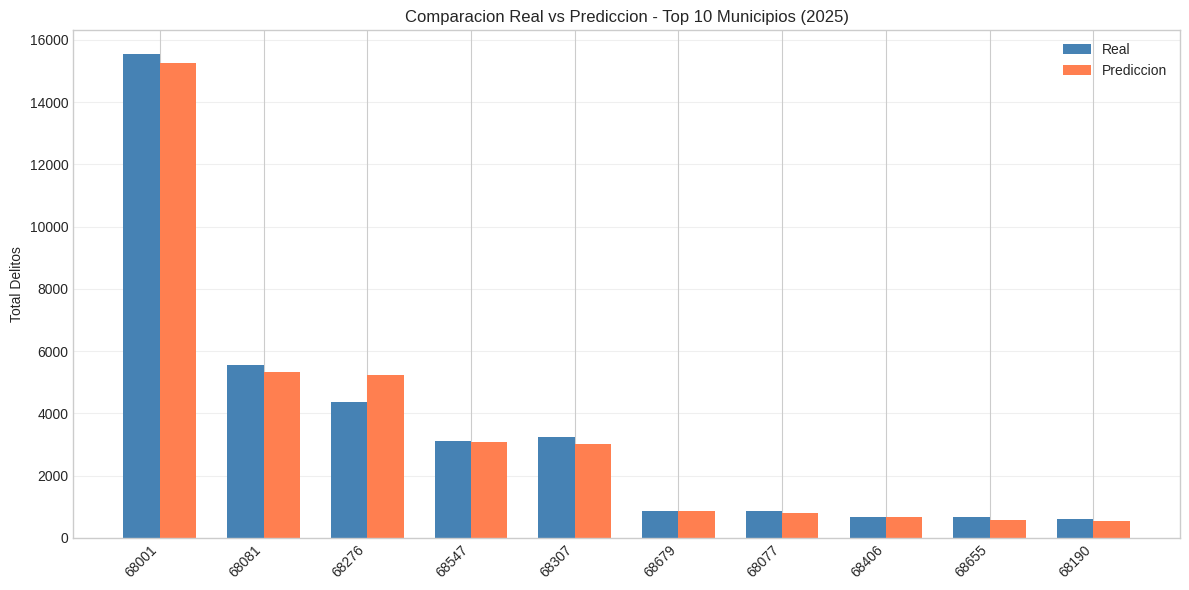

In [ ]:
# 8.2 Predicciones para todos los municipios (ultimo anio)
print("=" * 70)
print("PREDICCIONES PARA TODOS LOS MUNICIPIOS")
print("=" * 70)

# Filtrar datos del ultimo anio
df_ultimo_anio = df_model[df_model['anio'] == df_model['anio'].max()].copy()

# Preparar features
X_pred = df_ultimo_anio[feature_cols]

# Hacer predicciones
predicciones = modelo_cargado.predict(X_pred)
df_ultimo_anio['prediccion'] = predicciones
df_ultimo_anio['diferencia'] = df_ultimo_anio['total_delitos'] - df_ultimo_anio['prediccion']
df_ultimo_anio['error_pct'] = abs(df_ultimo_anio['diferencia']) / df_ultimo_anio['total_delitos'].clip(lower=1) * 100

# Mostrar top municipios
print("\n> Top 10 municipios con mas delitos predichos:")
top_pred = df_ultimo_anio.nlargest(10, 'prediccion')[['codigo_municipio', 'total_delitos', 'prediccion', 'diferencia', 'error_pct']]
top_pred.columns = ['Codigo', 'Real', 'Prediccion', 'Diferencia', 'Error %']
print(top_pred.to_string(index=False))

# Visualizacion
fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(top_pred))
width = 0.35
ax.bar([i - width/2 for i in x], top_pred['Real'], width, label='Real', color='steelblue')
ax.bar([i + width/2 for i in x], top_pred['Prediccion'], width, label='Prediccion', color='coral')
ax.set_xticks(x)
ax.set_xticklabels([str(c) for c in top_pred['Codigo']], rotation=45, ha='right')
ax.set_ylabel('Total Delitos')
ax.set_title(f'Comparacion Real vs Prediccion - Top 10 Municipios ({df_model["anio"].max()})')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

## 9. Resumen Final

Resumen del proceso de modelado y resultados obtenidos.

In [ ]:
# 9.1 Resumen del proceso
print("=" * 70)
print("RESUMEN DEL PROCESO DE MODELADO")
print("=" * 70)

print("""
> OBJETIVO
  Predecir el total de delitos anuales por municipio en Santander para
  apoyar la planificacion de recursos y estrategias de seguridad.

> DATOS UTILIZADOS
""")
print(f"  - Dataset: regression_annual_dataset.parquet")
print(f"  - Periodo: {df['anio'].min()} - {df['anio'].max()}")
print(f"  - Municipios: {df['codigo_municipio'].nunique()}")
print(f"  - Total registros: {len(df)}")

print("""
> PREPROCESAMIENTO
  - Ingenieria de caracteristicas (variables lag, tendencias)
  - Division temporal train/test
  - Escalado con StandardScaler
""")

print(f"> MODELOS EVALUADOS")
for i, nombre in enumerate(modelos.keys(), 1):
    print(f"  {i}. {nombre}")

print(f"""
> MEJOR MODELO
  - Tipo: {mejor_modelo_opt_nombre}
  - R2 Test: {metricas_test['R2']:.4f}
  - RMSE Test: {metricas_test['RMSE']:.2f}
  - MAE Test: {metricas_test['MAE']:.2f}
  - MAPE Test: {metricas_test['MAPE']:.2f}%
""")

print("> ARCHIVOS GENERADOS")
print(f"  - Modelo: {model_path}")
print(f"  - Scaler: {scaler_path}")
print(f"  - Metadatos: {metadata_path}")
print(f"  - Resumen: {resumen_path}")

print("""
> INTERPRETACION
  El modelo puede predecir con buena precision el total de delitos
  anuales por municipio, considerando factores demograficos, historicos
  y geograficos. Las variables mas importantes incluyen:
""")
if importancias_dict:
    for i, var in enumerate(list(importancias_dict.keys())[:5], 1):
        print(f"  {i}. {var}")

print("\n" + "=" * 70)
print("[OK] PROCESO COMPLETADO EXITOSAMENTE")
print("=" * 70)

RESUMEN DEL PROCESO DE MODELADO

> OBJETIVO
  Predecir el total de delitos anuales por municipio en Santander para
  apoyar la planificacion de recursos y estrategias de seguridad.

> DATOS UTILIZADOS

  - Dataset: regression_annual_dataset.parquet
  - Periodo: 2010 - 2025
  - Municipios: 87
  - Total registros: 1387

> PREPROCESAMIENTO
  - Ingenieria de caracteristicas (variables lag, tendencias)
  - Division temporal train/test
  - Escalado con StandardScaler

> MODELOS EVALUADOS
  1. LinearRegression
  2. Ridge
  3. Lasso
  4. ElasticNet
  5. RandomForest
  6. GradientBoosting
  7. XGBoost

> MEJOR MODELO
  - Tipo: XGBoost
  - R2 Test: 0.9929
  - RMSE Test: 141.79
  - MAE Test: 30.02
  - MAPE Test: 8.77%

> ARCHIVOS GENERADOS
  - Modelo: ../models/regression/annual/regression_annual_xgboost_20251128_181146.joblib
  - Scaler: ../models/regression/annual/scaler_20251128_181146.joblib
  - Metadatos: ../models/regression/annual/regression_annual_metadata_20251128_181146.json
  - Resumen